In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [22]:
# Data import
df = pd.read_csv('../data/fetal_health.csv')

In [23]:
# Split labels from Data
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

In [24]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# Binarize for ROC-curves (Multiclass)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

In [26]:
# Models and hyperparameter grids
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [None, 10, 20],
            "classifier__min_samples_split": [2, 5]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        "params": {
            "classifier__C": [0.1, 1, 10],
            "classifier__solver": ["lbfgs", "liblinear"]
        }
    },
    "SVM": {
        "model": SVC(class_weight='balanced', probability=True, random_state=42),
        "params": {
            "classifier__C": [0.1, 1, 10],
            "classifier__kernel": ["linear", "rbf"]
        }
    }
}


=== Training RandomForest ===
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

         1.0      0.978     0.934     0.955       332
         2.0      0.681     0.831     0.748        59
         3.0      0.865     0.914     0.889        35

    accuracy                          0.918       426
   macro avg      0.841     0.893     0.864       426
weighted avg      0.927     0.918     0.921       426

Balanced Accuracy: 0.8928430428736739
Confusion Matrix:
[[310  21   1]
 [  6  49   4]
 [  1   2  32]]


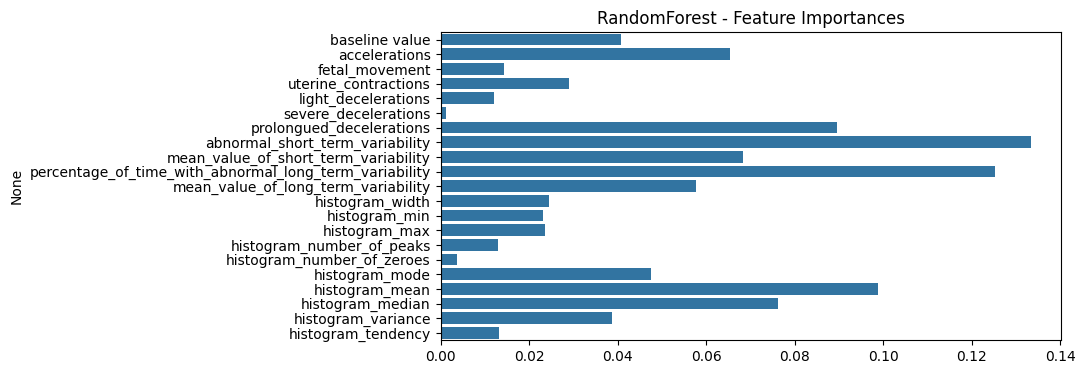

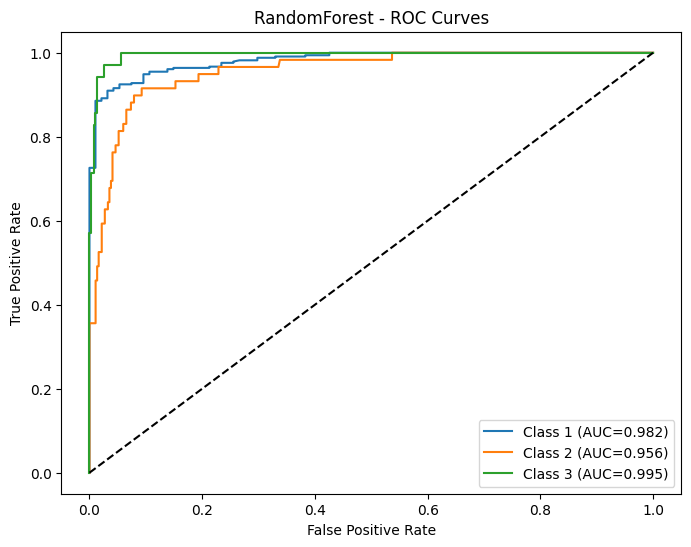


=== Training LogisticRegression ===


/home/repos/FetalHealthClassification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/repos/FetalHealthClassification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/repos/FetalHealthClassification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is depr

Best Parameters: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}
Classification Report:
              precision    recall  f1-score   support

         1.0      0.986     0.880     0.930       332
         2.0      0.528     0.797     0.635        59
         3.0      0.683     0.800     0.737        35

    accuracy                          0.862       426
   macro avg      0.733     0.825     0.767       426
weighted avg      0.898     0.862     0.873       426

Balanced Accuracy: 0.8253760805935606
Confusion Matrix:
[[292  35   5]
 [  4  47   8]
 [  0   7  28]]


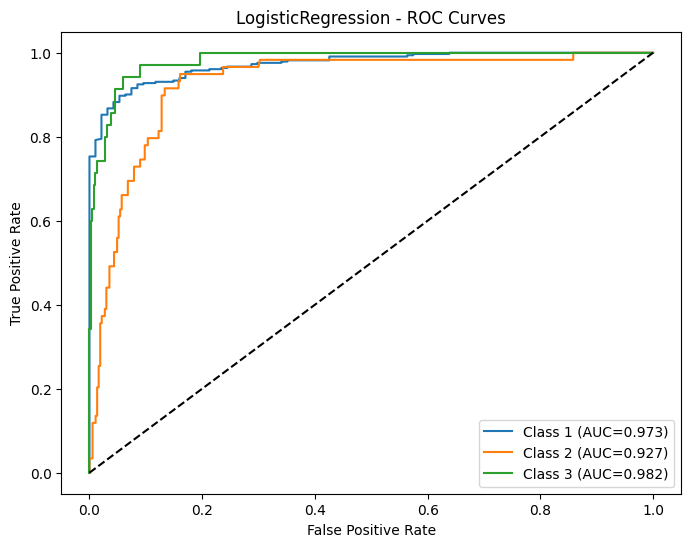


=== Training SVM ===
Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

         1.0      0.977     0.904     0.939       332
         2.0      0.595     0.847     0.699        59
         3.0      0.829     0.829     0.829        35

    accuracy                          0.890       426
   macro avg      0.800     0.860     0.822       426
weighted avg      0.912     0.890     0.897       426

Balanced Accuracy: 0.8598811711737994
Confusion Matrix:
[[300  29   3]
 [  6  50   3]
 [  1   5  29]]


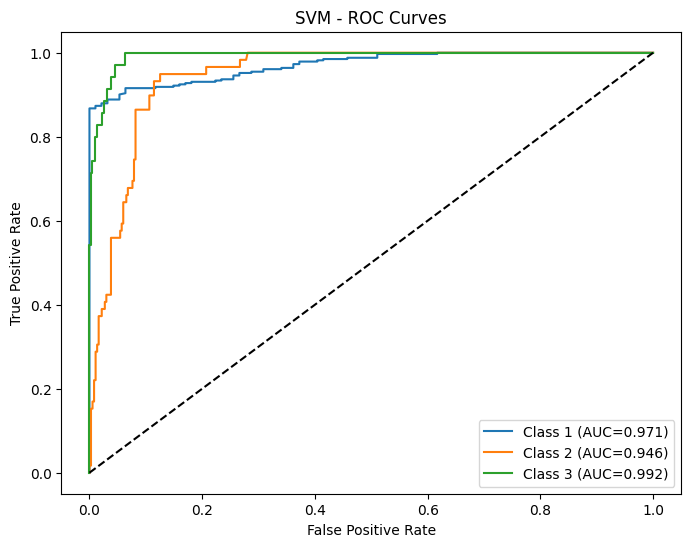

In [ ]:
# Pipeline, GridSearchCV and evaluation
best_models = {}

for model_name, mp in models.items():
    print(f"\n=== Training {model_name} ===")
    
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', mp['model'])
    ])
    
    grid = GridSearchCV(
        pipeline,
        param_grid=mp['params'],
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    print("Best Parameters:", grid.best_params_)
    
    y_pred = grid.predict(X_test)
    
    # Evaluation
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    best_models[model_name] = grid.best_estimator_
    
    # Feature importances
    if hasattr(grid.best_estimator_.named_steps['classifier'], "feature_importances_"):
        importances = grid.best_estimator_.named_steps['classifier'].feature_importances_
        features = X.columns
        plt.figure(figsize=(8,4))
        sns.barplot(x=importances, y=features)
        plt.title(f"{model_name} - Feature Importances")
        plt.show()
    
    # ROC curves (Multiclass)
    if hasattr(grid.best_estimator_.named_steps['classifier'], "predict_proba"):
        y_score = grid.best_estimator_.predict_proba(X_test)
        plt.figure(figsize=(8,6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {i+1} (AUC={roc_auc:.3f})")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curves")
        plt.legend()
        plt.show()


=== Modellvergleich ===
                Model  Balanced Accuracy  Macro F1-Score  Accuracy
0        RandomForest              0.893           0.864     0.918
2                 SVM              0.860           0.822     0.890
1  LogisticRegression              0.825           0.767     0.862


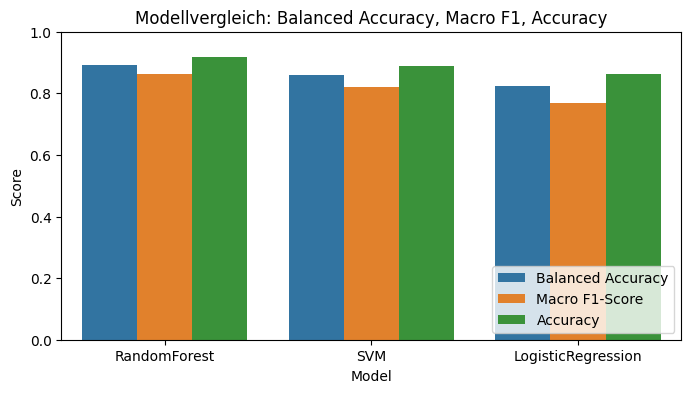

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Saving results
results = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        "Model": model_name,
        "Balanced Accuracy": round(bal_acc, 3),
        "Macro F1-Score": round(macro_f1, 3),
        "Accuracy": round(acc, 3)
    })

# Results as df
results_df = pd.DataFrame(results).sort_values(by="Balanced Accuracy", ascending=False)
print("\n=== Modellvergleich ===")
print(results_df)

# Visualization
plt.figure(figsize=(8,4))
sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Modellvergleich: Balanced Accuracy, Macro F1, Accuracy")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()
